# Rossman dataset 

Fuente lightgbm: https://lightgbm.readthedocs.io/en/stable/

https://www.kaggle.com/competitions/rossmann-store-sales/data

- Id - an Id that represents a (Store, Date) duple within the test set
- Store - a unique Id for each store
- Sales - the turnover for any given day (this is what you are predicting)
- Customers - the number of customers on a given day
- Open - an indicator for whether the store was open: 0 = closed, 1 = open
- StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
- StoreType - differentiates between 4 different store models: a, b, c, d
- Assortment - describes an assortment level: a = basic, b = extra, c = extended
- CompetitionDistance - distance in meters to the nearest competitor store
- CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
- Promo - indicates whether a store is running a promo on that day
- Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
- PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [3]:
import pandas as pd
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# ----------------------------
# CARGA Y PREPROCESAMIENTO
# ----------------------------
# Carga de datos
train = pd.read_csv('rossman.csv')
stores = pd.read_csv('store.csv')

# Merge de ambos datasets
df = pd.merge(train, stores, on='Store')

# Convertir la columna de fecha
df['Date'] = pd.to_datetime(df['Date'])

# Ordenar por fecha para evitar leakage
df = df.sort_values('Date')

# Filtrar solo tiendas abiertas
df = df[df['Open'] == 1]

# ----------------------------
# FEATURE ENGINEERING
# ----------------------------

# Variables temporales útiles
df['month'] = df['Date'].dt.month
df['day_of_month'] = df['Date'].dt.day
df['week_of_year'] = df['Date'].dt.isocalendar().week.astype(int)

# Eliminar columnas que no usaremos
df = df.drop(columns=['Date', 'Store', 'Customers', 'Open'])



C:\Users\ppmel\AppData\Local\Temp\ipykernel_7140\3898006585.py:10: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('rossman.csv')


In [4]:
# ----------------------------
# SEPARACIÓN TEMPORAL: 80% pasado, 20% futuro
# ----------------------------
split_index = int(len(df) * 0.8)
train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

# Separar X y y
target = 'Sales'
X_train = train_df.drop(columns=target)
y_train = train_df[target]
X_test = test_df.drop(columns=target)
y_test = test_df[target]

# Codificar variables categóricas (después del split para evitar leakage)
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Alinear columnas en test con train
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Asegura que los nombres de columna sean strings y estén limpios
X_train.columns = X_train.columns.str.replace(r'[^\w]', '_', regex=True)

X_test.columns = X_test.columns.str.replace(r'[^\w]', '_', regex=True)


### ⚙️ Tuneando LightGBM

- **`num_iterations`** (`n_estimators` en `sklearn`):  
  Número total de árboles a entrenar. Si usas `early_stopping_rounds`, puedes poner un número alto sin preocuparte por overfitting.

- **`max_depth`**:  
  Profundidad máxima de cada árbol. Profundidades mayores capturan más complejidad, pero pueden sobreajustar.

- **`learning_rate`**:  
  Qué tan rápido aprende el modelo. Valores más bajos requieren más árboles, pero suelen generalizar mejor.

- **`subsample`** (`bagging_fraction`):  
  Fracción de observaciones usadas en cada árbol. Ayuda a reducir overfitting. Requiere activar también `bagging_freq`.

- **`feature_fraction`** (equivalente a `colsample_bytree` en XGBoost):  
  Fracción de columnas (features) usadas en cada árbol. También ayuda a evitar sobreajuste.

- **`early_stopping_rounds`**:  
  Detiene el entrenamiento si la métrica en el conjunto de validación no mejora en N iteraciones. Requiere `valid_sets` y `eval_metric`.

- **`metric`** (`eval_metric` en sklearn):  
  Métrica usada durante entrenamiento para monitorear desempeño (ej: `'rmse'`, `'mae'`, `'binary_logloss'`, `'auc'`).

- **`min_data_in_leaf`**:  
  Número mínimo de muestras requeridas en una hoja. Sirve para evitar sobreajuste. Similar a `min_child_samples` en XGBoost y `min_data_in_leaf` en CatBoost.

- **`lambda_l2`** (`reg_lambda` en sklearn):  
  Regularización L2 (Ridge) aplicada a los pesos de las hojas. Ayuda a controlar la complejidad.

- **`min_gain_to_split`** (`gamma` en XGBoost):  
  Ganancia mínima necesaria para hacer un split. Controla qué tan fácilmente el árbol se ramifica → útil contra overfitting.


    eval_set=[(X_train, y_train), (X_test, y_test)],
    callbacks=[
        early_stopping(20),
        log_evaluation(100)
    ]

In [5]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.metrics import r2_score

# Definir modelo
model = LGBMRegressor(
    n_estimators=10000,
    num_leaves=10,
    max_depth=5,
    learning_rate=0.1,
    colsample_bytree=0.8, 
    subsample=0.8,              
    metric='rmse',
    verbosity=-1  
)

# Entrenar
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    callbacks=[
        early_stopping(20),
        log_evaluation(100)
    ]
)

# Extraer resultados
results = model.evals_result_

# Predicción y métricas
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.4f}")


Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 2247.8	valid_1's rmse: 2311.62
[200]	training's rmse: 2034.12	valid_1's rmse: 2111.21
[300]	training's rmse: 1878.92	valid_1's rmse: 1969.95
[400]	training's rmse: 1758.68	valid_1's rmse: 1860.77
[500]	training's rmse: 1671.47	valid_1's rmse: 1779.67
[600]	training's rmse: 1585.37	valid_1's rmse: 1701.58
[700]	training's rmse: 1495.36	valid_1's rmse: 1610.77
[800]	training's rmse: 1442.72	valid_1's rmse: 1560.81
[900]	training's rmse: 1390.66	valid_1's rmse: 1514.07
[1000]	training's rmse: 1343.31	valid_1's rmse: 1469.38
[1100]	training's rmse: 1304.87	valid_1's rmse: 1439.98
[1200]	training's rmse: 1272.82	valid_1's rmse: 1414.55
[1300]	training's rmse: 1249.67	valid_1's rmse: 1399.36
[1400]	training's rmse: 1226.28	valid_1's rmse: 1380.2
[1500]	training's rmse: 1201.03	valid_1's rmse: 1356.79
[1600]	training's rmse: 1180.22	valid_1's rmse: 1339.81
[1700]	training's rmse: 1160.9	valid_1's rmse: 1326.9


### Cross validation 

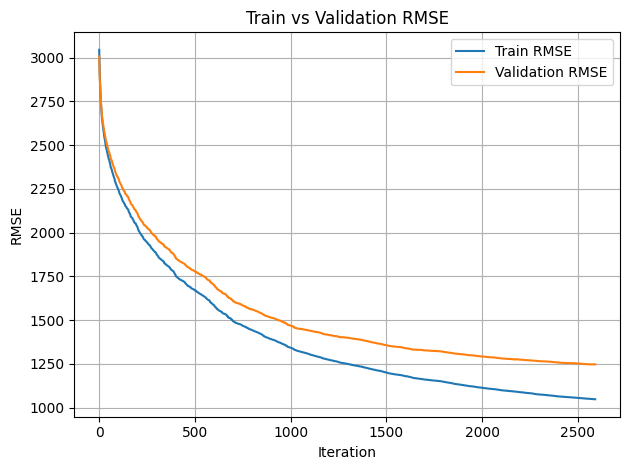

In [6]:
plt.plot(results['training']['rmse'], label='Train RMSE')
plt.plot(results['valid_1']['rmse'], label='Validation RMSE')
plt.xlabel('Iteration')
plt.ylabel('RMSE')

plt.title('Train vs Validation RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Feature importances 

In [7]:
importancias = pd.DataFrame({
    'features': X_train.keys(),
    'importancia': model.feature_importances_
})
importancias = importancias.sort_values('importancia', ascending=False)
importancias

,features,importancia
3,CompetitionDistance,6601
4,CompetitionOpenSinceMonth,2429
5,CompetitionOpenSinceYear,2308
0,DayOfWeek,1858
7,Promo2SinceWeek,1554
11,week_of_year,1371
10,day_of_month,1168
1,Promo,1057
8,Promo2SinceYear,945
20,Assortment_c,785


### Gain
Ganancia total que aportó una feature en todos los splits donde fue usada	

### Weight
Número de veces que una feature fue usada para hacer un split	

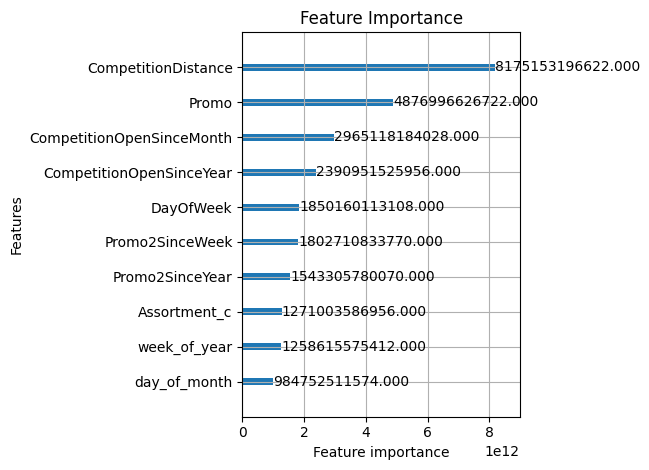

In [8]:
import lightgbm as lgb
# Gráfico de importancia
lgb.plot_importance(model, importance_type='gain', max_num_features=10)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

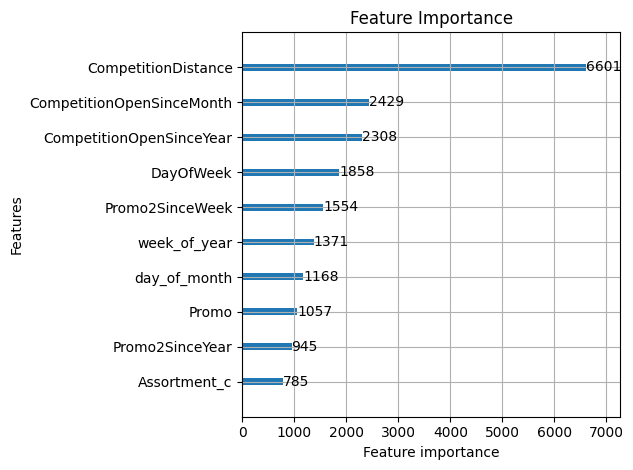

In [9]:
import lightgbm as lgb
# Gráfico de importancia
lgb.plot_importance(model, importance_type='split', max_num_features=10)
plt.title("Feature Importance")
plt.tight_layout()
plt.show()

### Aplicando shap values

Corre: 
```
pip install shap
```

### 1- Calcula los shap values

In [10]:
import shap 

# Sample de 10K loans 
X_shap= X_test.sample(10000)
# Inicializa los shaps explainer SHAP, shap.TreeExplainer
explainer = shap.TreeExplainer(model)
# explainer.shap_values
shap_values = explainer.shap_values(X_shap)

### 2- Ejemplos de predicciones

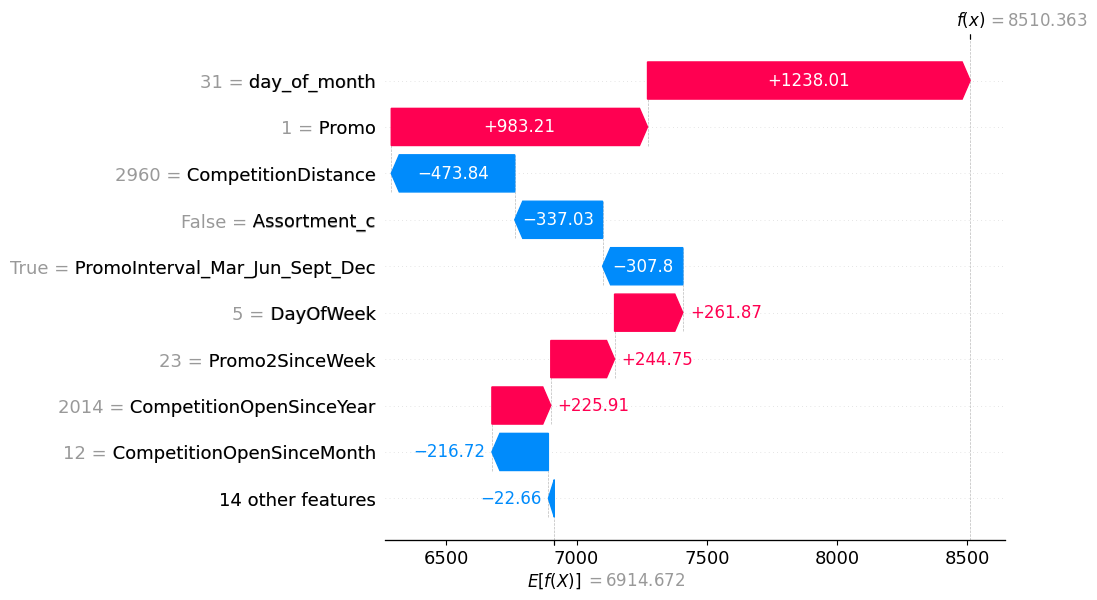

In [14]:
# Incicializa los shaps  initjs()
shap.initjs()
# Para visualizar shap individual con waterfall plot
# input: shap.Explanation(values=shaps[0])
shap.waterfall_plot(shap.Explanation(values=shap_values[0]
                                     
                    ,base_values=explainer.expected_value,
                    data=X_shap.iloc[0],feature_names=X_shap.keys()))

### Todas las variables

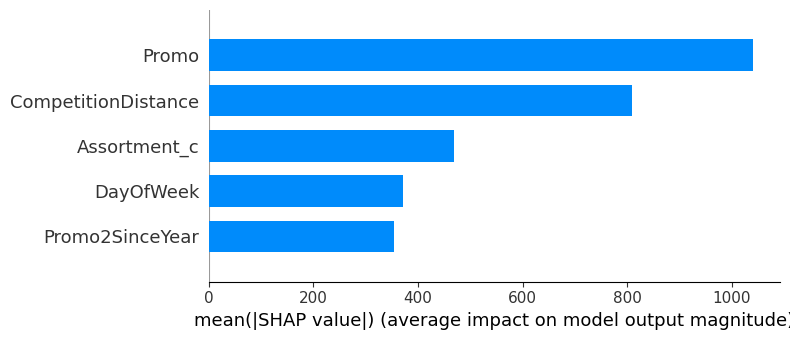

In [16]:
# Sumaruy plot, input: shap_values, X y plot type
shap.summary_plot(shap_values, X_shap, plot_type="bar",max_display=5)

### Dotplot

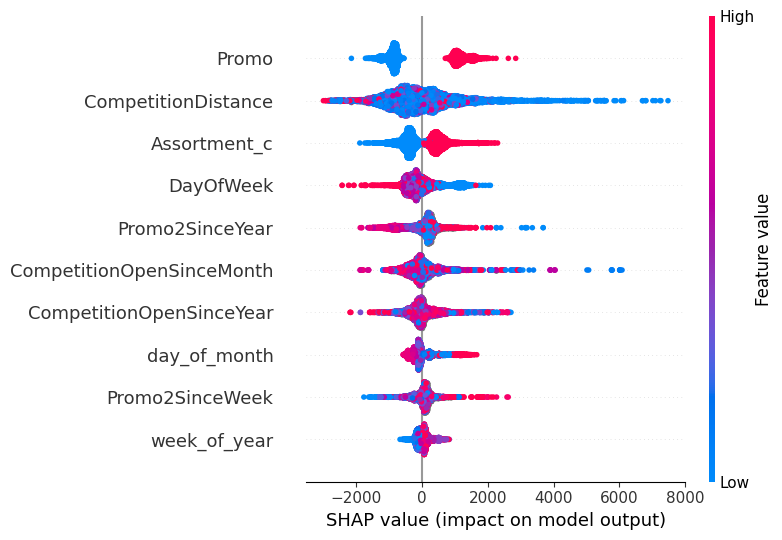

In [18]:
# Dot plot, mismos imputs, plot type="dot"
shap.summary_plot(shap_values, X_shap, plot_type="dot",max_display=10)

# Efecto individual por feature

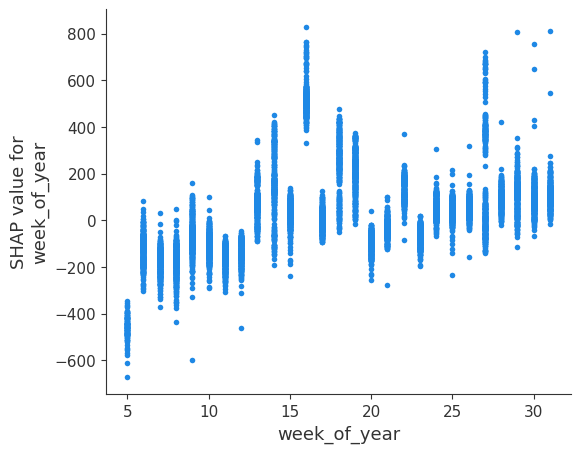

In [20]:
# shap.dependance_plot(i, shaps, X_shap, interaction_index=None, show=False)

shap.dependence_plot('week_of_year', shap_values, X_shap, interaction_index=None, show=False)




In [41]:
dia_tienda= X_shap.sample(1,random_state=42)


In [42]:
dia_tienda_contrafactual= dia_tienda.copy()
dia_tienda_contrafactual['Promo']=0

In [43]:
model.predict(dia_tienda)


array([10002.57338936])

In [44]:
model.predict(dia_tienda_contrafactual)

array([6527.16996092])